# Segmentación de Lunares usando Image Processing

Esqueleto para la tarea T04.


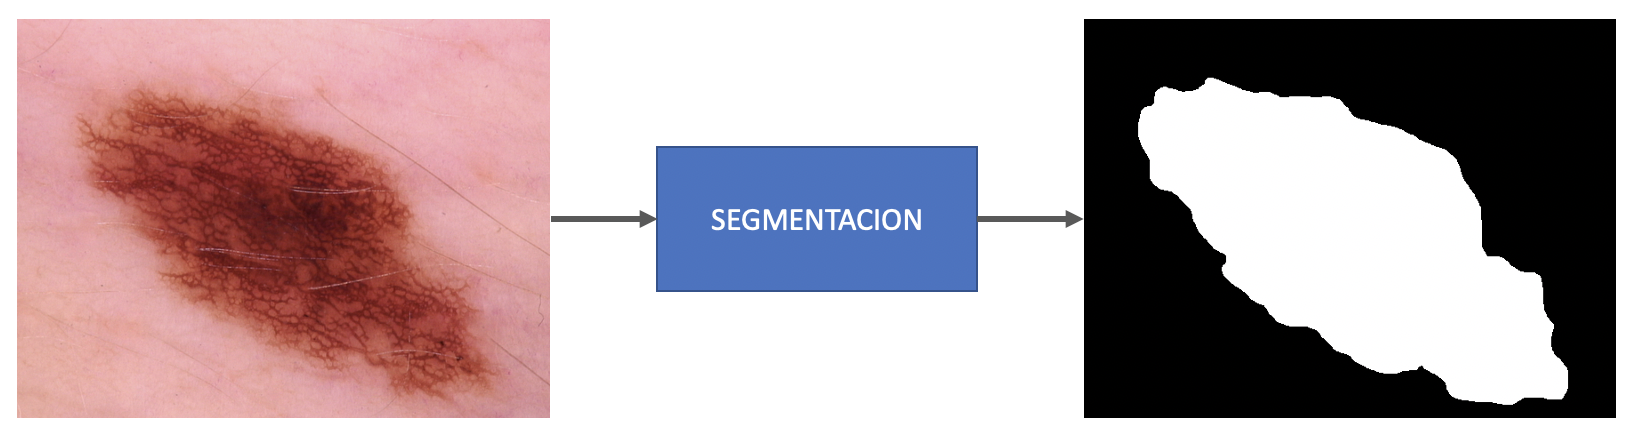

# Descarga de datos

Se descarga las imágenes a color en la carpeta `skin/color` y la segmentación manual en la carpeta `skin/seg`.

In [1]:
!wget https://www.dropbox.com/scl/fi/g6e5lofrcpr8uffejdzrz/skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0
!mv skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0 skinseg20.zip
!unzip -qq skinseg20.zip

--2024-11-28 18:56:30--  https://www.dropbox.com/scl/fi/g6e5lofrcpr8uffejdzrz/skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf8b4d175671251bf5c441a2d8.dl.dropboxusercontent.com/cd/0/inline/CfSSAq6OcBguZhRAGihA5EPBjKhab2fBAar-E21M2teaNGgIfc_Q7soCM_wfSwU0ZfWi9za_p6rAEL-qSX0wevDfrDqpSDKKvvlh2PvtzQLrHSM5WrLxYdATt5RcYPNBw5g/file# [following]
--2024-11-28 18:56:30--  https://ucaf8b4d175671251bf5c441a2d8.dl.dropboxusercontent.com/cd/0/inline/CfSSAq6OcBguZhRAGihA5EPBjKhab2fBAar-E21M2teaNGgIfc_Q7soCM_wfSwU0ZfWi9za_p6rAEL-qSX0wevDfrDqpSDKKvvlh2PvtzQLrHSM5WrLxYdATt5RcYPNBw5g/file
Resolving ucaf8b4d175671251bf5c441a2d8.dl.dropboxusercontent.com (ucaf8b4d175671251bf5c441a2d8.dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to u

# Setup iniciales

In [2]:
from   skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fnmatch
import os
from   tqdm.auto import tqdm

# Funciones

In [3]:
def regionview(img, mask):
    img_color = np.dstack((img, img, img)) # colores
    img_color = label2rgb(mask, image=img_color, bg_label=0)
    return img_color

def dirfiles(img_path, img_ext,full=False,noext=False):
    """
    Carga las imágenes
    """
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    if noext:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_names[i][:-4]
    return img_names

def skin_read(st):
  """
  Indica si algo es lunar o no
  """
  sti   = 'skinseg20/color/'+st+'.jpg'
  sts   = 'skinseg20/seg/'+st+'_seg.jpg'
  Itest = cv2.cvtColor(cv2.imread(sti), cv2.COLOR_BGR2RGB)
  GT    = cv2.imread(sts)[:,:,0]>128
  return Itest,GT

def skin_show(img,GT,D):
    """
    Muestra la imagen
    """
    imgs  = regionview(img[:,:,0],D)
    f = plt.figure()
    f.add_subplot(1,4,1); plt.imshow(img); plt.axis('off'); plt.title('original')
    f.add_subplot(1,4,2); plt.imshow(GT); plt.axis('off'); plt.title('GT')
    f.add_subplot(1,4,3); plt.imshow(D,cmap="gray"); plt.axis('off'); plt.title('seg')
    f.add_subplot(1,4,4); plt.imshow(imgs); plt.axis('off'); plt.title('seg')
    plt.show()

def skin_performance(GT,D):
  """
  Calcula la precisión y el recall
  """
  TP = np.sum(np.multiply(D==1,GT==1))
  FP = np.sum(np.multiply(D==1,GT==0))
  FN = np.sum(np.multiply(D==0,GT==1))
  return TP,FP,FN


# Diseño del algoritmo de segmentación

In [28]:
def touches_border(contour, img_shape, threshold=100):
    """
    Este código se aplica en la función skin_segmentation de abajo,
    filtra aquellas zonas que otsu detectó que tocan los bordes de la imagen si lo tocan en más pixeles que el thr.
    Esto porque sabemos que las imágenes dadas en este código no tocan los bordes.
    """
    h, w = img_shape[:2]
    count = 0
    for point in contour:
        x, y = point[0]
        if x == 0 or y == 0 or x == w - 1 or y == h - 1:
            count += 1
    return count > threshold

In [29]:
# este código se basa en: https://stackoverflow.com/questions/52858115/how-to-remove-hair-from-skin-images-using-opencv
import cv2
import numpy as np
import matplotlib.pyplot as plt

def skin_segmentation(img, threshold=10):

    red_channel = img[:, :, 2]  # extraemos un solo canal
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # tipo de ecualización de hist que me funcionó mejor
    red_channel = clahe.apply(red_channel)

# ------------------------------------------------
    # f = plt.figure()
    # f.add_subplot(1, 3, 1)
    # plt.imshow(red_channel, cmap='gray')
    # plt.axis('off')
    # plt.title('Original')
# ------------------------------------------------

    _, otsu_mask = cv2.threshold(red_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # hacemos otsu

    # creamos varias máscaras para operaciones morfológicas de erosión y dilatación que usaremos después
    kernel1 = np.ones((4, 4), np.uint8)  # erosión: quita cabellos, no todos, pues se perdía parte de i = 9 con una máscara mayor
    kernel2 = np.ones((17, 17), np.uint8)  # erosión y dilatación: rellena completamente el lunar y genera un perímetro más homogéneo

    eroded = cv2.erode(otsu_mask, kernel1, iterations=1) # aplicamos el primer kernel
    blurred = cv2.GaussianBlur(eroded, (5, 5), 0) # suavizamos la imagen para unir segmentos disconectos del lunar

# ------------------------------------------------
    # f.add_subplot(1, 3, 2)
    # plt.imshow(blurred, cmap='gray')
    # plt.axis('off')
    # plt.title('otsu bonito')
# ------------------------------------------------

    # Encontrar contornos en la máscara de Otsu:
    contours, _ = cv2.findContours(blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None  # Si no hay contornos, retornar None

    valid_contours = [cnt for cnt in contours if not touches_border(cnt, img.shape)] # aplicamos la función de tocar bordes
    # Si no hay contornos válidos, retornar None
    if not valid_contours:
        return None

    cnt = max(valid_contours, key=cv2.contourArea) # una vez filtrados los bordes, se elige el mayor, que debería ser el lunar

    # Creamos una máscara con el contorno más grande
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    dilated = cv2.dilate(mask, kernel1, iterations=1) # Aplicamos la dilatación para restaurar la forma tras la erosión
    dilated = cv2.dilate(dilated, kernel2, iterations=1) # aplicamos otra dilatación para hacer más bonita la forma
    eroded = cv2.erode(dilated, kernel2, iterations=1) # volvemos a erosionar para restaurar la forma

# ------------------------------------------------
    # res = cv2.bitwise_and(img, img, mask=eroded)
    # f.add_subplot(1, 3, 3)
    # plt.imshow(cv2.cvtColor(res, cv2.COLOR_RGB2GRAY), cmap='gray')
    # plt.axis('off')
    # plt.title('lunar final')
    # plt.show()
# ------------------------------------------------

    final_mask = eroded > 0 # volvemos la imagen booleana

    return final_mask

Idea: mostrar la imagen solo en el canal de rojo y hacer un kernel que mida la diferencia entre cada pixel, si es mayor a 20, marcar.

# Lista de imágenes

In [30]:
img_names = dirfiles('skinseg20/color', '*.jpg',noext=True) # warning: seg_names[i] debe ser ...
n = len(img_names)
print(f'Number of images = {n}')


Number of images = 20


# Prueba del algoritmo para una imagen

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
1113 1150 10
Precision = 0.4918
Recall    = 0.9911


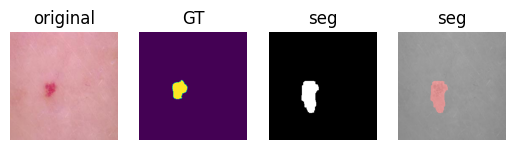

In [31]:
i        = 1
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
print(D)
TP,FP,FN = skin_performance(GT,D)
print(TP, FP, FN)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)


Precision = 0.6750
Recall    = 1.0000


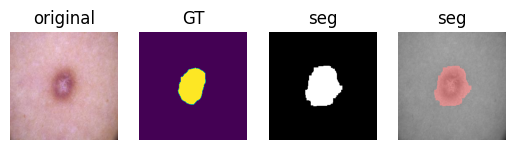

In [32]:
i        = 2
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.8650
Recall    = 0.9313


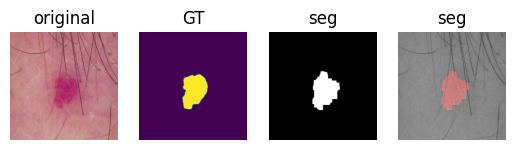

In [33]:
i        = 3
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9997
Recall    = 0.7563


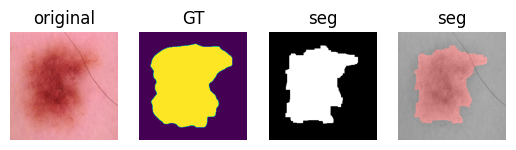

In [34]:
i        = 4
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9550
Recall    = 0.9527


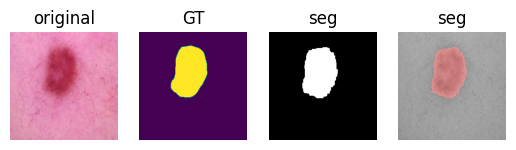

In [35]:
i        = 5
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9751
Recall    = 0.9327


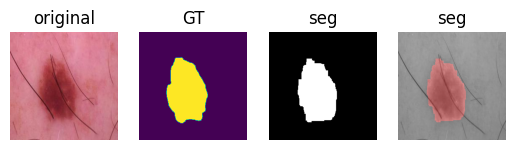

In [36]:
i        = 6
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.8187
Recall    = 0.9767


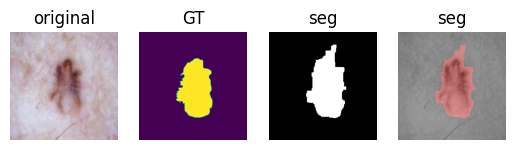

In [37]:
i        = 7
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.7732
Recall    = 0.9778


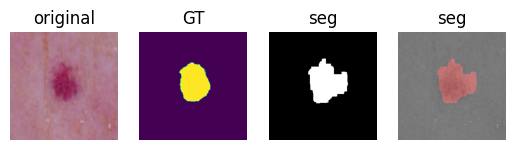

In [38]:
i        = 8
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9941
Recall    = 0.8476


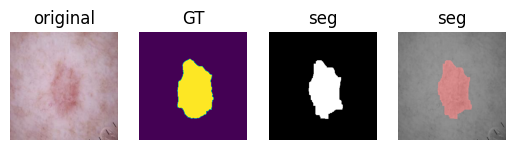

In [39]:
i        = 9
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9942
Recall    = 0.6750


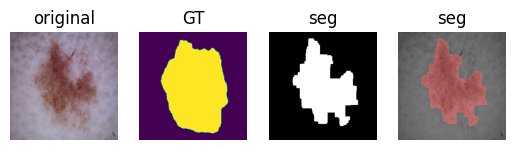

In [40]:
i        = 10
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9491
Recall    = 0.9877


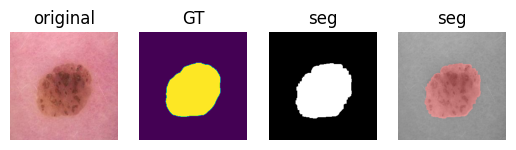

In [41]:
i        = 11
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9723
Recall    = 0.8520


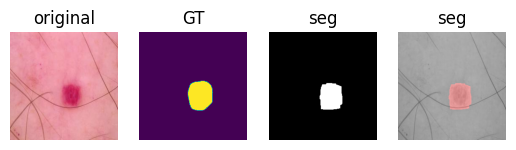

In [42]:
i        = 12
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9928
Recall    = 0.9350


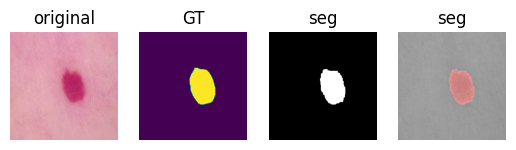

In [43]:
i        = 13
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 1.0000
Recall    = 0.5196


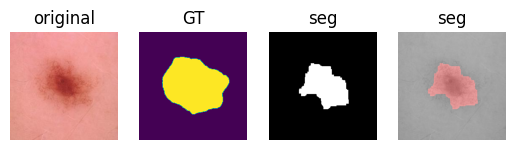

In [44]:
i        = 14
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.7368
Recall    = 1.0000


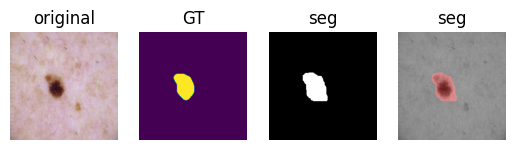

In [45]:
i        = 15
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9641
Recall    = 0.7855


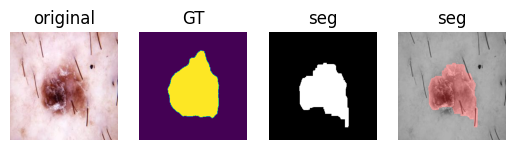

In [46]:
i        = 16
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9821
Recall    = 0.9438


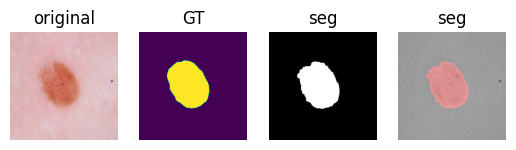

In [47]:
i        = 17
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9667
Recall    = 0.9736


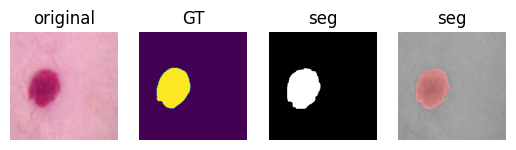

In [48]:
i        = 18
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9761
Recall    = 0.9526


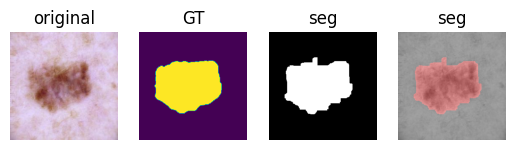

In [49]:
i        = 19
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.8431
Recall    = 0.9930


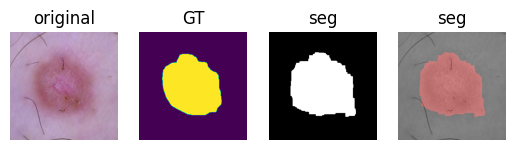

In [50]:
i        = 0
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

# Medición de desempeño

In [51]:
TP = 0
FP = 0
FN = 0
for i in tqdm(range(n)):
  st          = img_names[i]
  Itest,GT    = skin_read(st)
  D           = skin_segmentation(Itest)
  TPi,FPi,FNi = skin_performance(GT,D)
  TP          = TP+TPi
  FP          = FP+FPi
  FN          = FN+FNi
Pr = TP/(TP+FP)
Re = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Precision = 0.9274
Recall    = 0.8469
